$$\Large \textit{C0708 | Reconocimiento de Patrones}$$

$$\large \textbf{Ejercicio práctico | Visualización y pre-procesamiento de datos}$$

_Profesor: Moisés Meza, Jesus Alvarado_

_Alumnos: Luis Revilla, Sebastian Ríos, Emilio Ochoa_

**PAF Challenge database:**

Esta base de datos de registros de ECG de dos canales se ha creado para su uso en el Computers in Cardiology Challenge 2001, un concurso abierto con el objetivo de desarrollar métodos automatizados para predecir la fibrilación auricular paroxística (FAP). 




_Moody GB, Goldberger AL, McClennen S, Swiryn SP. Predicting the Onset of Paroxysmal Atrial Fibrillation: The Computers in Cardiology Challenge 2001. Computers in Cardiology 28:113-116 (2001)._

# Data Acquisition

In [ ]:
!pip -q install lazypredict
#Installamos lazy predict, para comparar diversas herramientas de procesamiento 
#Y analizar junto a nuestra observacion del data set, cual seria el analisis optimo
#Para obtener los mejores resultados

In [ ]:
!pip install wfdb --upgrade
!pip install biosppy
#Para poder observar los datos .hea .gea .ada 
#Incluidos en la carpeta de datos


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 3.4 MB/s eta 0:00:00


In [ ]:
#Importamos algunas librerias basicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import biosppy
import wfdb

In [ ]:
!wget -r -N -c -np https://physionet.org/files/afpdb/1.0.0/
#Jalamos la informacion desde physionet
#Dado que los 2gb de inf. podrian complicar la replicabilidad del codigo

In [ ]:
#Cambiamos el directorio de trabajo de este notebook
%cd /content/physionet.org/files/afpdb/1.0.0/

/content/physionet.org/files/afpdb/1.0.0


In [ ]:
#Apreciamos como se ve una señal ECG desde la base de datos, que se comporta 
#Como un array

registro = wfdb.rdrecord('n01')
ecg = registro.p_signal.flatten()

In [ ]:
ecg
#Vemos un ejemplo de una senal ecg muestra usando la libreria wfdb

array([-1.5000e-02,  0.0000e+00, -1.5000e-02, ...,  5.0000e-03,
       -1.0285e+01, -1.0285e+01])

# Preprocessing

## Feature engineering

In [ ]:
import biosppy.signals.ecg as ecg

ruta_datos = '/content/physionet.org/files/afpdb/1.0.0/'
af_patients = ['n{:02d}'.format(i) for i in range(1, 50)]
no_af_patients = ['p{:02d}'.format(i) for i in range(1, 50)]
#Clasificamos a los pacientes diferencialos por fibrilacion
#Analizando el dataset vimos que N hace referencia a tener y P a no tener

pacientes = af_patients + no_af_patients
#Unimos y tenemos el dataset de pacientes

# Crear arrays para las características y las etiquetas, dado que no tenian originalmente
caracteristicas = []
etiquetas = []

# Iterar sobre los pacientes
for paciente in pacientes:
    record = wfdb.rdrecord(ruta_datos + paciente)
    annotation = wfdb.rdann(ruta_datos + paciente, 'qrs')
    
    # Extraer características relevantes del ECG con Biosppy
    out = ecg.ecg(signal=record.p_signal[:, 0], sampling_rate=record.fs, show=False)
    mean_hr = np.mean(out['heart_rate'])
    std_hr = np.std(out['heart_rate'])
    mean_rri = np.mean(np.diff(annotation.sample) / record.fs)
    std_rri = np.std(np.diff(annotation.sample) / record.fs)
    
    # Clasificar al paciente según si tiene fibrilación auricular o no
    if 'p' in paciente:
        etiqueta = 1 # Paciente con fibrilación auricular
    else:
        etiqueta = 0 # Paciente sin fibrilación auricular
    
    # Añadir características y etiquetas a los arrays
    caracteristicas.append([mean_hr, std_hr, mean_rri, std_rri])
    etiquetas.append(etiqueta)
    
# Convertir características y etiquetas a arrays de Numpy
caracteristicas = np.array(caracteristicas)
etiquetas = np.array(etiquetas)




In [ ]:
df = pd.DataFrame(caracteristicas, columns=['heart_rate', 'std_hr', 'mean_rri', 'std_rri'])
df['atr'] = etiquetas #Desiganmos una nueva columna con las etiquetas hayadas anteriormente

Dataframe obtenido: contiene frecuencia cardiaca, desviación estándar, promedio de intervalo QRS, etc.

In [ ]:
df.head(10)

,heart_rate,std_hr,mean_rri,std_rri,atr
0,92.584966,4.199534,0.649633,0.034030,0
1,81.844107,3.458647,0.734467,0.031912,0
2,83.179694,4.407431,0.721793,0.067926,0
3,84.570249,5.565045,0.716020,0.093290,0
4,107.803736,17.937889,0.572350,0.095464,0
5,102.458644,14.429032,0.598885,0.095308,0
6,59.669976,5.146921,1.017521,0.032123,0
7,62.525106,0.439381,0.959683,0.008178,0
8,93.879684,5.140459,0.632939,0.073844,0
9,76.926002,5.384319,0.782469,0.067856,0


In [ ]:
df.columns #Observamos las nuevas columnas creadas

Index(['Mean Heart Rate', 'Std Heart Rate', 'Mean RRI', 'Std RRI', 'Cluster'], dtype='object')

# Exploratory Data Analysis

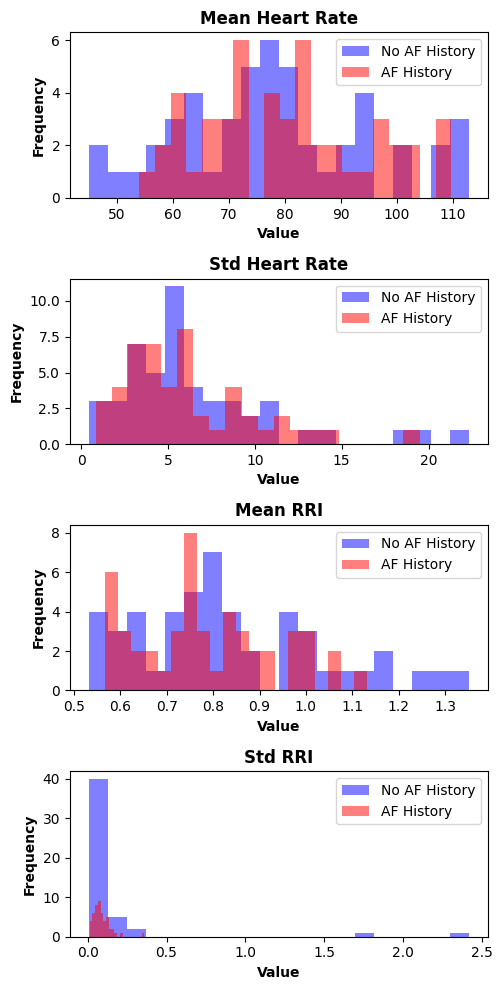

In [ ]:
# Histograma para cada variable en la lista respecto a la variable objetivo

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(5,10))
for i, var in enumerate(df.drop('Cluster', axis=1).columns):
    axs[i].hist(df[df['Cluster']==0][var], alpha=0.5, bins=20, label='No AF History', color='blue')
    axs[i].hist(df[df['Cluster']==1][var], alpha=0.5, bins=20, label='AF History', color='red')
    axs[i].set_title(var, fontsize=12, weight='bold')
    axs[i].set_xlabel('Value', fontsize=10, weight='bold')
    axs[i].set_ylabel('Frequency', fontsize=10, weight='bold')
    axs[i].legend(loc='upper right')
    
plt.tight_layout()
plt.show()

Vemos que no existe una distribución normal en todas las variables, y teniendo en cuenta la presencia de outliers, optamos por un Robust Scaler para el escalamiento de los datos.

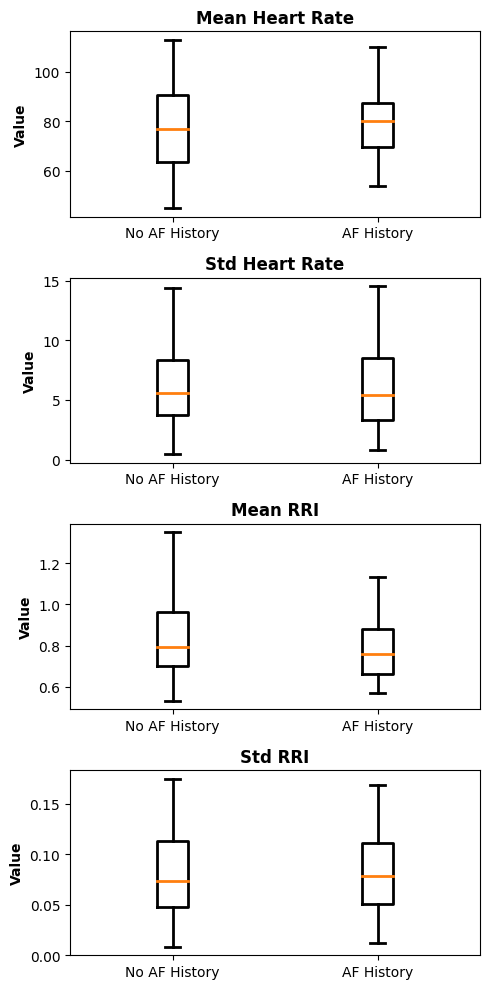

In [ ]:
# Boxplot para cada variable en la lista respecto a la variable objetivo

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(5,10))
for i, var in enumerate(df.drop('Cluster', axis=1).columns):
    axs[i].boxplot([df[df['Cluster']==0][var], df[df['Cluster']==1][var]], 
                   labels=['No AF History', 'AF History'], 
                   showfliers=False, 
                   boxprops=dict(linewidth=2),
                   whiskerprops=dict(linewidth=2),
                   capprops=dict(linewidth=2),
                   medianprops=dict(linewidth=2))
    axs[i].set_title(var, fontsize=12, weight='bold')
    axs[i].set_ylabel('Value', fontsize=10, weight='bold')
    
plt.tight_layout()
plt.show()


In [ ]:
etiquetas

In [ ]:
caracteristicas

# Extra: Revisión con modelos de aprendizaje automático no supervisado

Consideramos la opción de un aprendizaje no supervisado, a ver si pudiese encontrar clusters entre los pacientes sin historial de Fibrilación Auricular, y los que sí tienen antecedentes.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Randomizar los datos
caracteristicas, etiquetas = shuffle(caracteristicas, etiquetas, random_state=0)

# Crear pipeline para escalar los datos
escalador = StandardScaler()
pipeline = make_pipeline(escalador, KMeans(n_clusters=2, random_state=0))

# Realizar K-means clustering con k=2
pipeline.fit(caracteristicas)

# Obtener las etiquetas predichas
etiquetas_predichas = pipeline.predict(caracteristicas)

# Obtener los centroides de cada cluster
centroides = pipeline.named_steps['kmeans'].cluster_centers_

# Obtener los pacientes que pertenecen a cada cluster
cluster_0 = []
cluster_1 = []
for i, etiqueta in enumerate(etiquetas_predichas):
    if etiqueta == 0:
        cluster_0.append(pacientes[i])
    else:
        cluster_1.append(pacientes[i])

# Imprimir los resultados
print("Cluster 0: ", cluster_0)
print("Cluster 1: ", cluster_1)


Cluster 0:  ['n01', 'n06', 'n08', 'n10', 'n12', 'n15', 'n16', 'n17', 'n21', 'n22', 'n24', 'n32', 'n33', 'n34', 'n36', 'n39', 'n40', 'n41', 'n46', 'n47', 'n49', 'p01', 'p02', 'p04', 'p05', 'p06', 'p09', 'p10', 'p11', 'p12', 'p13', 'p15', 'p17', 'p19', 'p20', 'p27', 'p28', 'p31', 'p32', 'p37', 'p40', 'p42', 'p46']
Cluster 1:  ['n02', 'n03', 'n04', 'n05', 'n07', 'n09', 'n11', 'n13', 'n14', 'n18', 'n19', 'n20', 'n23', 'n25', 'n26', 'n27', 'n28', 'n29', 'n30', 'n31', 'n35', 'n37', 'n38', 'n42', 'n43', 'n44', 'n45', 'n48', 'p03', 'p07', 'p08', 'p14', 'p16', 'p18', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p29', 'p30', 'p33', 'p34', 'p35', 'p36', 'p38', 'p39', 'p41', 'p43', 'p44', 'p45', 'p47', 'p48', 'p49']


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Los resultados no son alentadores, probamos visualizando la data a ver si hay algún agrupamiento

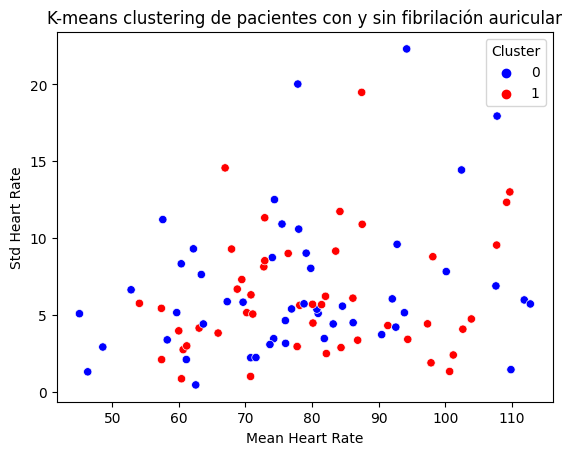

In [ ]:
import seaborn as sns
import matplotlib as plt

# Convertir los datos a un DataFrame de Pandas y agregar etiquetas de cluster
df = pd.DataFrame(data=caracteristicas, columns=['Mean Heart Rate', 'Std Heart Rate', 'Mean RRI', 'Std RRI'])
df['Cluster'] = etiquetas

# Graficar los puntos en el espacio de características, colorean los puntos según su etiqueta de cluster
sns.scatterplot(data=df, x='Mean Heart Rate', y='Std Heart Rate', hue='Cluster', palette=['blue', 'red'])

# Agregar título
plt.pyplot.title('K-means clustering de pacientes con y sin fibrilación auricular')

# Mostrar la figura
plt.pyplot.show()


Teniendo en cuenta los resultados, al menos por ahora, no es el mejor camino aplicar un modelo de aprendizaje no supervisado.

# Modelo supervisado con pipeline

Comparativa de Logistic Regression, Decision Tree y Random Forest

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
import xgboost as xgb

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(caracteristicas, etiquetas, test_size=0.2, random_state=0)

# Crear pipeline para escalar los datos y aplicar el modelo de Regresión Logística
pipe_lr = make_pipeline(RobustScaler(), LogisticRegression(random_state=0))

# Crear pipeline para escalar los datos y aplicar el modelo de XGBoost
pipe_xgb = make_pipeline(RobustScaler(), xgb.XGBClassifier(random_state=0, learning_rate=0.1, max_depth=3, n_estimators=100, objective='binary:logistic'))

# Crear pipeline para escalar los datos y aplicar el modelo de Bosques Aleatorios
pipe_rf = make_pipeline(RobustScaler(), RandomForestClassifier(random_state=0, n_estimators=100, max_depth=5, min_samples_split=5))

# Entrenar los modelos
pipe_lr.fit(X_train, y_train)
pipe_xgb.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)

# Evaluar la precisión de los modelos
print("Precisión Regresión Logística: {:.2f}".format(pipe_lr.score(X_test, y_test)))
print("Precisión XGBoost: {:.2f}".format(pipe_xgb.score(X_test, y_test)))
print("Precisión Bosques Aleatorios: {:.2f}".format(pipe_rf.score(X_test, y_test)))



Precisión Regresión Logística: 0.40
Precisión XGBoost: 0.60
Precisión Bosques Aleatorios: 0.40


Comprobación con LazyClassifier

In [ ]:
from lazypredict.Supervised import LazyClassifier

scaler = RobustScaler()
caracteristicas_scaled = scaler.fit_transform(caracteristicas)


X_train, X_test, y_train, y_test = train_test_split(caracteristicas_scaled, etiquetas, random_state =123, test_size=0.3)
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)

models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [00:03<00:00,  7.80it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LabelPropagation,0.57,0.60,0.60,0.58,0.02
LabelSpreading,0.57,0.60,0.60,0.58,0.02
CalibratedClassifierCV,0.40,0.55,0.55,0.30,0.05
LGBMClassifier,0.43,0.50,0.50,0.43,0.09
NuSVC,0.47,0.50,0.50,0.48,0.03
DummyClassifier,0.33,0.50,0.50,0.17,0.03
SGDClassifier,0.53,0.50,0.50,0.54,0.04
RandomForestClassifier,0.50,0.50,0.50,0.51,0.63
Perceptron,0.53,0.50,0.50,0.54,0.03


Aplicación de PCA

In [ ]:
# Ahora probamos con PCA

from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
pca.fit(caracteristicas_scaled)
X_pca = pca.transform(caracteristicas_scaled)

pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])

pca_df

,PC1,PC2
0,-0.18,0.85
1,-0.02,-1.57
2,-0.97,-0.28
3,0.74,-0.59
4,-0.03,-0.07
...,...,...
93,-1.28,-1.82
94,-1.94,1.24
95,0.58,-1.24
96,-1.54,-0.15


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(pca_df, etiquetas, random_state =123, test_size=0.3)
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)

models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [00:01<00:00, 24.90it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
DecisionTreeClassifier,0.60,0.65,0.65,0.61,0.02
XGBClassifier,0.60,0.62,0.62,0.61,0.04
LabelPropagation,0.57,0.62,0.62,0.57,0.02
LabelSpreading,0.57,0.62,0.62,0.57,0.02
NearestCentroid,0.53,0.55,0.55,0.55,0.07
CalibratedClassifierCV,0.40,0.55,0.55,0.30,0.05
NuSVC,0.57,0.55,0.55,0.58,0.04
BaggingClassifier,0.57,0.55,0.55,0.58,0.05
QuadraticDiscriminantAnalysis,0.40,0.53,0.53,0.33,0.01


## Método de Ensemble

In [ ]:
# modelos multioutputs

from sklearn.naive_bayes import CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, StackingClassifier, HistGradientBoostingClassifier, VotingClassifier


In [ ]:
scaler = RobustScaler()
caracteristicas_scaled = scaler.fit_transform(caracteristicas)


X_train, X_test, y_train, y_test = train_test_split(caracteristicas_scaled, etiquetas, random_state =123, test_size=0.3)

In [ ]:
#mdl_NB = CategoricalNB()
mdl_knn = KNeighborsClassifier(n_neighbors=5)
mdl_svm = SVC(kernel="rbf")
mdl_tree = DecisionTreeClassifier()
mdl_ensemble = RandomForestClassifier(random_state=0)
mdl_bagg = BaggingClassifier()
mdl_grad = GradientBoostingClassifier()
mdl_His = HistGradientBoostingClassifier()
#mdl_vot = VotingClassifier()

In [ ]:
list_mdl = [ mdl_knn, mdl_svm, mdl_tree, mdl_ensemble, mdl_bagg, mdl_grad,mdl_His ]
names_mdl = ["knn","svc","tree","randomforest","adaboost","bagging","gradientBoosting","histgradientBoosting"]
y_mdl_pred = list()

In [ ]:
from sklearn.model_selection import cross_val_score
from tabulate import tabulate

In [ ]:
print("{:>15} {:>15}".format(*["Model","score"]))
for n, mdl in enumerate(list_mdl):
    score = cross_val_score(mdl, caracteristicas_scaled,etiquetas, cv=5)
    #print(names_mdl[n],": \t\t",  np.round(score.mean(),2))
    show_values = [names_mdl[n],  np.round(score.mean(),2)]
    print("{:>20} {:>20}".format(*show_values))

          Model           score
                 knn                 0.46
                 svc                 0.52
                tree                 0.47
        randomforest                 0.47
            adaboost                 0.42
             bagging                 0.44
    gradientBoosting                 0.42


In [ ]:
for mdl in list_mdl:
    mdl.fit(X_train, y_train)
    y_mdl_pred.append(mdl.predict(X_test))

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
for n,i in enumerate(y_mdl_pred):
    print(names_mdl[n],": \n", classification_report(y_test, i), '\n')

knn : 
               precision    recall  f1-score   support

           0       0.50      0.30      0.37        20
           1       0.22      0.40      0.29        10

    accuracy                           0.33        30
   macro avg       0.36      0.35      0.33        30
weighted avg       0.41      0.33      0.35        30
 

svc : 
               precision    recall  f1-score   support

           0       0.57      0.20      0.30        20
           1       0.30      0.70      0.42        10

    accuracy                           0.37        30
   macro avg       0.44      0.45      0.36        30
weighted avg       0.48      0.37      0.34        30
 

tree : 
               precision    recall  f1-score   support

           0       0.67      0.50      0.57        20
           1       0.33      0.50      0.40        10

    accuracy                           0.50        30
   macro avg       0.50      0.50      0.49        30
weighted avg       0.56      0.50      0.51  

Considerando esto, vemos que al usar métodos de ensemble obtenemos una precisión de hasta el 75% para la predicción de pacientes con antecedentes de Fibrilación Auricular a partir de ciertas características extraídas de sus señales ECG. 